In [1]:
#Import the required libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [2]:
#Load dataset
df = pd.read_csv('Datasets/Password_Strength_Dataset_2.csv') 

#Data cleaning
df_dropna = df.dropna()  

#Shuffle dataset for randomness and robustness
data = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [3]:
#Feature Extraction
def password_length(password):
    return len(password)

def count_digits(password):
    return sum(char.isdigit() for char in password)

def count_uppercase(password):
    return sum(char.isupper() for char in password)

def count_special_characters(password):
    return sum(not char.isalnum() for char in password)

data['length'] = data['Passwords'].apply(password_length)
data['digits'] = data['Passwords'].apply(count_digits)
data['uppercase'] = data['Passwords'].apply(count_uppercase)
data['special_chars'] = data['Passwords'].apply(count_special_characters)

In [4]:
#Check the unique lengths of passwords
print(data['length'].unique())

[ 24  27  55  87  73  34  30  80  16   9  12  23  38  43  14  44   6   7
  85  20  37   5  13  10  81  11  42  82  50  22  35  95  78  31  26  17
  25   8 117  67  63  40 103  86  36 108  74  70 112 110  19  98  59 126
  84  49 124  29  68  58  45  39  47  62  60  32  33  93  21  53  88  79
  64  48  77  71  76  75  15  83  89  99  56  18  91  97  54  46  28  69
  72  41 120  92 101  66  94  61 114 100 115  96   4  90  57 118  52 105
  51 111 102 128 107 119 122  65 106 109 104 146 132 127 113 129 116 121
 125 137 123 134 135 138 145 130 131 155 139 142 136 150 140 144 141 133
 168 149 147 148 143 154 165 152 153 190 156 162 159 151 158 173 170 157
 160 196 169]


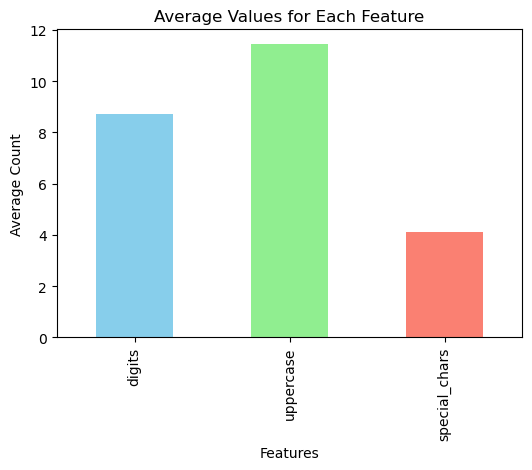

In [5]:
# Create a DataFrame
df = pd.DataFrame(data)

# Calculate the average (mean) for each feature column
avg_values = df[['digits', 'uppercase', 'special_chars']].mean()

# Plot a bar graph for the average values
plt.figure(figsize=(6, 4))
avg_values.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])

# Adding titles and labels
plt.title('Average Values for Each Feature')
plt.xlabel('Features')
plt.ylabel('Average Count')

# Show the plot
plt.show()

In [6]:
# Group the data by the 'length' column
grouped = data.groupby('length')

group_counts = grouped.size()

#print("Counts of each group:")
#print(group_counts)

# Print the highest count
highest_count = group_counts.max()
highest_length = group_counts.idxmax()
print(f"Highest count: {highest_count} for length {highest_length}")

# Print the lowest count
lowest_count = group_counts.min()
lowest_length = group_counts.idxmin()
print(f"Lowest count: {lowest_count} for length {lowest_length}")

#Verify the count for specific length
specific_length = 7 

# Print the size for the specific length
specific_length_count = group_counts.get(specific_length, 0)
print(f"Count for length {specific_length}: {specific_length_count}")

Highest count: 10164 for length 10
Lowest count: 1 for length 156
Count for length 7: 8613


In [7]:

#Check the labels for all the lengths
#for length, group in grouped:
#    unique_strengths = group['Strength'].unique()
#    print(f"Unique values for length {length}: {unique_strengths}")


In [8]:
# Choose a specific group to run the code on
selected_length = 24
selected_group = grouped.get_group(selected_length)

In [9]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the passwords
X_password = vectorizer.fit_transform(selected_group['Passwords'])
X_additional = selected_group[[ 'digits', 'uppercase', 'special_chars']].values
X = hstack([X_password, X_additional])

# Encode the labels
y = selected_group['Strength']

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resample data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

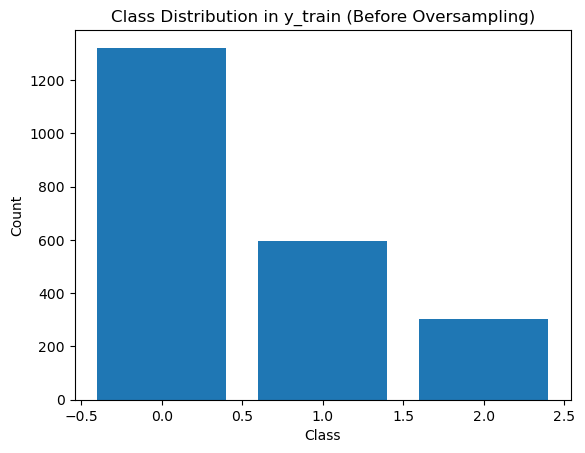

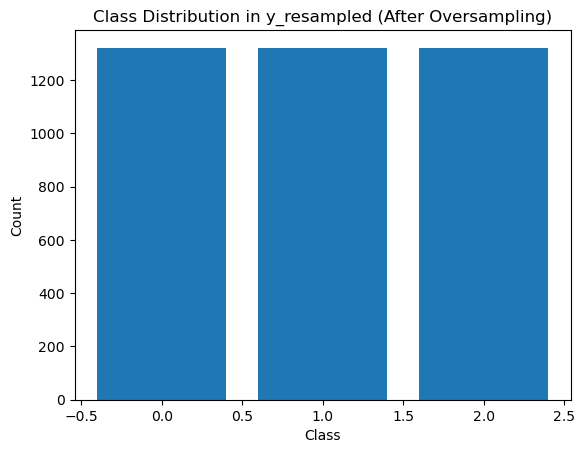

In [11]:
# Plot class distribution
def plot_class_distribution(y, title):
    class_counts = pd.Series(y).value_counts()
    plt.bar(class_counts.index, class_counts.values)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

plot_class_distribution(y_train, 'Class Distribution in y_train (Before Oversampling)')
plot_class_distribution(y_resampled, 'Class Distribution in y_resampled (After Oversampling)')


In [12]:
# Function to train the model 
def train_model(model, X_train, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    return model, training_time

In [13]:
# Function to evaluate the model on both training and testing data
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate the evaluation metrics for both training and testing data
    metrics = {
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Train Precision': precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
        'Test Precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'Train Recall': recall_score(y_train, y_train_pred, average='weighted'),
        'Test Recall': recall_score(y_test, y_test_pred, average='weighted'),
        'Train F1 Score': f1_score(y_train, y_train_pred, average='weighted'),
        'Test F1 Score': f1_score(y_test, y_test_pred, average='weighted')
    }
    
    classification_rep = classification_report(y_test, y_test_pred, zero_division=0)
    
    return metrics, classification_rep

In [14]:
# Function to print the metrics 
def print_metrics(model_name, metrics, classification_rep, training_time):
    print(f"\n{model_name} Training Time: {training_time:.2f} seconds")
    print(f"{model_name} Training Accuracy: {metrics['Train Accuracy']:.3f}")
    print(f"{model_name} Test Accuracy: {metrics['Test Accuracy']:.3f}")
    print(f"{model_name} Training Precision: {metrics['Train Precision']:.3f}")
    print(f"{model_name} Test Precision: {metrics['Test Precision']:.3f}")
    print(f"{model_name} Training Recall: {metrics['Train Recall']:.3f}")
    print(f"{model_name} Test Recall: {metrics['Test Recall']:.3f}")
    print(f"{model_name} Training F1 Score: {metrics['Train F1 Score']:.3f}")
    print(f"{model_name} Test F1 Score: {metrics['Test F1 Score']:.3f}")
    print("\nClassification Report on Test Data:")
    print(classification_rep)

In [15]:
# Function to plot the learning curve of the model
def plot_learning_curve(model, X, y, model_name):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Get learning curve data
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, cv=kfold, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10), 
        scoring='accuracy'
    )
    
    # Calculate mean and standard deviation for training and validation scores
    train_mean = np.mean(train_scores, axis=1)
    validation_mean = np.mean(validation_scores, axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, validation_mean, 'o-', color='green', label='Validation score')
    
    plt.fill_between(train_sizes, train_mean - np.std(train_scores, axis=1), 
                     train_mean + np.std(train_scores, axis=1), alpha=0.1, color='blue')
    plt.fill_between(train_sizes, validation_mean - np.std(validation_scores, axis=1), 
                     validation_mean + np.std(validation_scores, axis=1), alpha=0.1, color='green')
    
    plt.title(f'Learning Curve ({model_name})')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Determine the point of convergence
    convergence_point = np.argmax(validation_mean)
    convergence_score = validation_mean[convergence_point]
    
    print(f"\n{model_name} converges at {train_sizes[convergence_point]} training examples with a validation score of {convergence_score:.3f}")
    
    return train_sizes[convergence_point], convergence_score

In [16]:
#Function to Plot metrics
def plot_metrics(metrics):
    labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    train_metrics = {
        'Logistic Regression': [metrics['Logistic Regression']['Train Accuracy'], 
                                metrics['Logistic Regression']['Train Precision'], 
                                metrics['Logistic Regression']['Train Recall'], 
                                metrics['Logistic Regression']['Train F1 Score']],
        'Decision Tree': [metrics['Decision Tree']['Train Accuracy'], 
                          metrics['Decision Tree']['Train Precision'], 
                          metrics['Decision Tree']['Train Recall'], 
                          metrics['Decision Tree']['Train F1 Score']],
        'Random Forest': [metrics['Random Forest']['Train Accuracy'], 
                          metrics['Random Forest']['Train Precision'], 
                          metrics['Random Forest']['Train Recall'], 
                          metrics['Random Forest']['Train F1 Score']]
    }
    
    test_metrics = {
        'Logistic Regression': [metrics['Logistic Regression']['Test Accuracy'], 
                                metrics['Logistic Regression']['Test Precision'], 
                                metrics['Logistic Regression']['Test Recall'], 
                                metrics['Logistic Regression']['Test F1 Score']],
        'Decision Tree': [metrics['Decision Tree']['Test Accuracy'], 
                          metrics['Decision Tree']['Test Precision'], 
                          metrics['Decision Tree']['Test Recall'], 
                          metrics['Decision Tree']['Test F1 Score']],
        'Random Forest': [metrics['Random Forest']['Test Accuracy'], 
                          metrics['Random Forest']['Test Precision'], 
                          metrics['Random Forest']['Test Recall'], 
                          metrics['Random Forest']['Test F1 Score']]
    }

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(2, 1, figsize=(14, 13))
    colors = ['lightblue', 'lightgreen', 'salmon']

    # Plot training metrics
    for i, (label, values) in enumerate(train_metrics.items()):
        bars = ax[0].bar(x + i * width, values, width, label=label, color=colors[i])
        autolabel(bars, ax[0])

    ax[0].set_xlabel('Metrics')
    ax[0].set_ylabel('Scores')
    ax[0].set_title('Comparison of Training Metrics Across Models')
    ax[0].set_xticks(x + width)
    ax[0].set_xticklabels(labels)
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[0].set_ylim(0, 1.1)

    # Plot testing metrics
    for i, (label, values) in enumerate(test_metrics.items()):
        bars = ax[1].bar(x + i * width, values, width, label=label, color=colors[i])
        autolabel(bars, ax[1])

    ax[1].set_xlabel('Metrics')
    ax[1].set_ylabel('Scores')
    ax[1].set_title('Comparison of Testing Metrics Across Models')
    ax[1].set_xticks(x + width)
    ax[1].set_xticklabels(labels)
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[1].set_ylim(0, 1.1)

    fig.tight_layout()
    plt.show()

def autolabel(bars, ax):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')




In [17]:
def plot_computational_time(training_times):
    models = list(training_times.keys())
    times = list(training_times.values())
    
    plt.figure(figsize=(8, 5))
    
    # Plot the computational time as a line graph
    plt.plot(models, times, marker='o', color='salmon', linestyle='-', linewidth=2, markersize=8)
    
    # Add labels and title
    plt.title('Computational Time of Different Models')
    plt.xlabel('Model')
    plt.ylabel('Training Time (seconds)')
    
    # Annotate each marker with its exact value
    for model, time in zip(models, times):
        plt.annotate(f'{time:.2f}',  # Format the time to two decimal places
                     (model, time),  # Position of the annotation
                     textcoords="offset points",  # Coordinate system for the offset
                     xytext=(0, 5),  # Move the text closer to the marker (5 points above)
                     ha='center',  # Center the text horizontally
                     fontsize=9,  # Font size of the annotation
                     color='black')  # Color of the annotation text
    
    # Show the plot with grid
    plt.grid(True)
    plt.show()

In [18]:
#Initialize the ML models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

model_metrics = {}
convergence_points = {}


In [19]:
# Train the Logistic Regression model
print("Training Logistic Regression...")
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
trained_logistic_model, logistic_training_time = train_model(logistic_model, X_train, y_train)
logistic_metrics, logistic_classification_rep = evaluate_model(trained_logistic_model, X_train, y_train, X_test, y_test)
model_metrics['Logistic Regression'] = logistic_metrics
print_metrics('Logistic Regression', logistic_metrics, logistic_classification_rep, logistic_training_time)


Training Logistic Regression...

Logistic Regression Training Time: 0.35 seconds
Logistic Regression Training Accuracy: 0.994
Logistic Regression Test Accuracy: 0.991
Logistic Regression Training Precision: 0.994
Logistic Regression Test Precision: 0.991
Logistic Regression Training Recall: 0.994
Logistic Regression Test Recall: 0.991
Logistic Regression Training F1 Score: 0.994
Logistic Regression Test F1 Score: 0.991

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       0.98      0.99      0.98       135
           2       0.97      0.96      0.97        77

    accuracy                           0.99       556
   macro avg       0.98      0.98      0.98       556
weighted avg       0.99      0.99      0.99       556



Plotting learning curve for Logistic Regression...


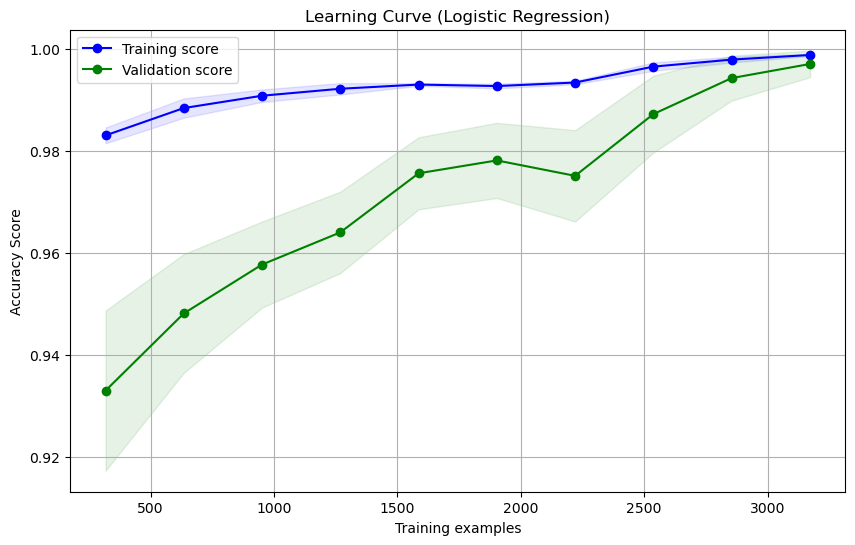


Logistic Regression converges at 3172 training examples with a validation score of 0.997


In [20]:
#Plot the learning curve for Logistic Regression
print("Plotting learning curve for Logistic Regression...")
logistic_point, logistic_score = plot_learning_curve(trained_logistic_model, X_resampled, y_resampled, 'Logistic Regression')
convergence_points['Logistic Regression'] = (logistic_point, logistic_score)


In [21]:
# Train the Decision Tree model
print("Training Decision Tree...")
decision_tree_model = DecisionTreeClassifier(random_state=42)
trained_decision_tree_model, decision_tree_training_time = train_model(decision_tree_model, X_train, y_train)
decision_tree_metrics, decision_tree_classification_rep = evaluate_model(trained_decision_tree_model, X_train, y_train, X_test, y_test)
model_metrics['Decision Tree'] = decision_tree_metrics
print_metrics('Decision Tree', decision_tree_metrics, decision_tree_classification_rep, decision_tree_training_time)


Training Decision Tree...

Decision Tree Training Time: 0.03 seconds
Decision Tree Training Accuracy: 1.000
Decision Tree Test Accuracy: 1.000
Decision Tree Training Precision: 1.000
Decision Tree Test Precision: 1.000
Decision Tree Training Recall: 1.000
Decision Tree Test Recall: 1.000
Decision Tree Training F1 Score: 1.000
Decision Tree Test F1 Score: 1.000

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00        77

    accuracy                           1.00       556
   macro avg       1.00      1.00      1.00       556
weighted avg       1.00      1.00      1.00       556



Plotting learning curve for Decision Tree...


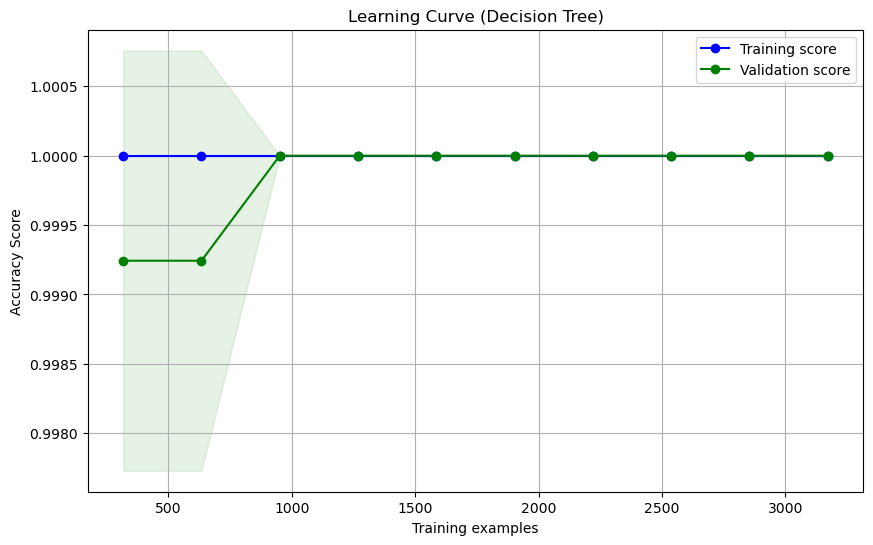


Decision Tree converges at 951 training examples with a validation score of 1.000


In [22]:
#Plot the learning curve for Decision Tree
print("Plotting learning curve for Decision Tree...")
decision_tree_point, decision_tree_score = plot_learning_curve(trained_decision_tree_model, X_resampled, y_resampled, 'Decision Tree')
convergence_points['Decision Tree'] = (decision_tree_point, decision_tree_score)


In [23]:
# Train the Random Forest model
print("Training Random Forest...")
random_forest_model = RandomForestClassifier(random_state=42)
trained_random_forest_model, random_forest_training_time = train_model(random_forest_model, X_train, y_train)
random_forest_metrics, random_forest_classification_rep = evaluate_model(trained_random_forest_model, X_train, y_train, X_test, y_test)
model_metrics['Random Forest'] = random_forest_metrics
print_metrics('Random Forest', random_forest_metrics, random_forest_classification_rep, random_forest_training_time)


Training Random Forest...

Random Forest Training Time: 1.43 seconds
Random Forest Training Accuracy: 1.000
Random Forest Test Accuracy: 1.000
Random Forest Training Precision: 1.000
Random Forest Test Precision: 1.000
Random Forest Training Recall: 1.000
Random Forest Test Recall: 1.000
Random Forest Training F1 Score: 1.000
Random Forest Test F1 Score: 1.000

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00        77

    accuracy                           1.00       556
   macro avg       1.00      1.00      1.00       556
weighted avg       1.00      1.00      1.00       556



Plotting learning curve for Random Forest...


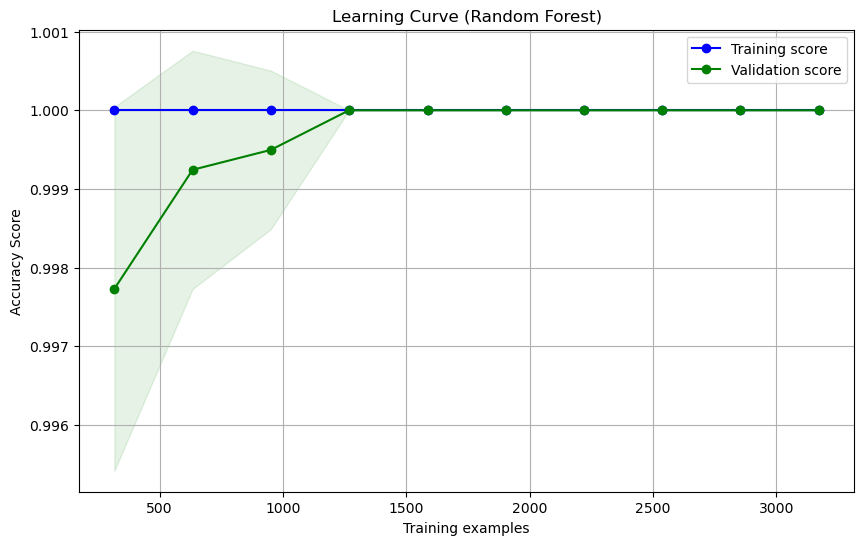


Random Forest converges at 1268 training examples with a validation score of 1.000


In [24]:
#Plot the learning curve for Random Forest
print("Plotting learning curve for Random Forest...")
random_forest_point, random_forest_score = plot_learning_curve(trained_random_forest_model, X_resampled, y_resampled, 'Random Forest')
convergence_points['Random Forest'] = (random_forest_point, random_forest_score)


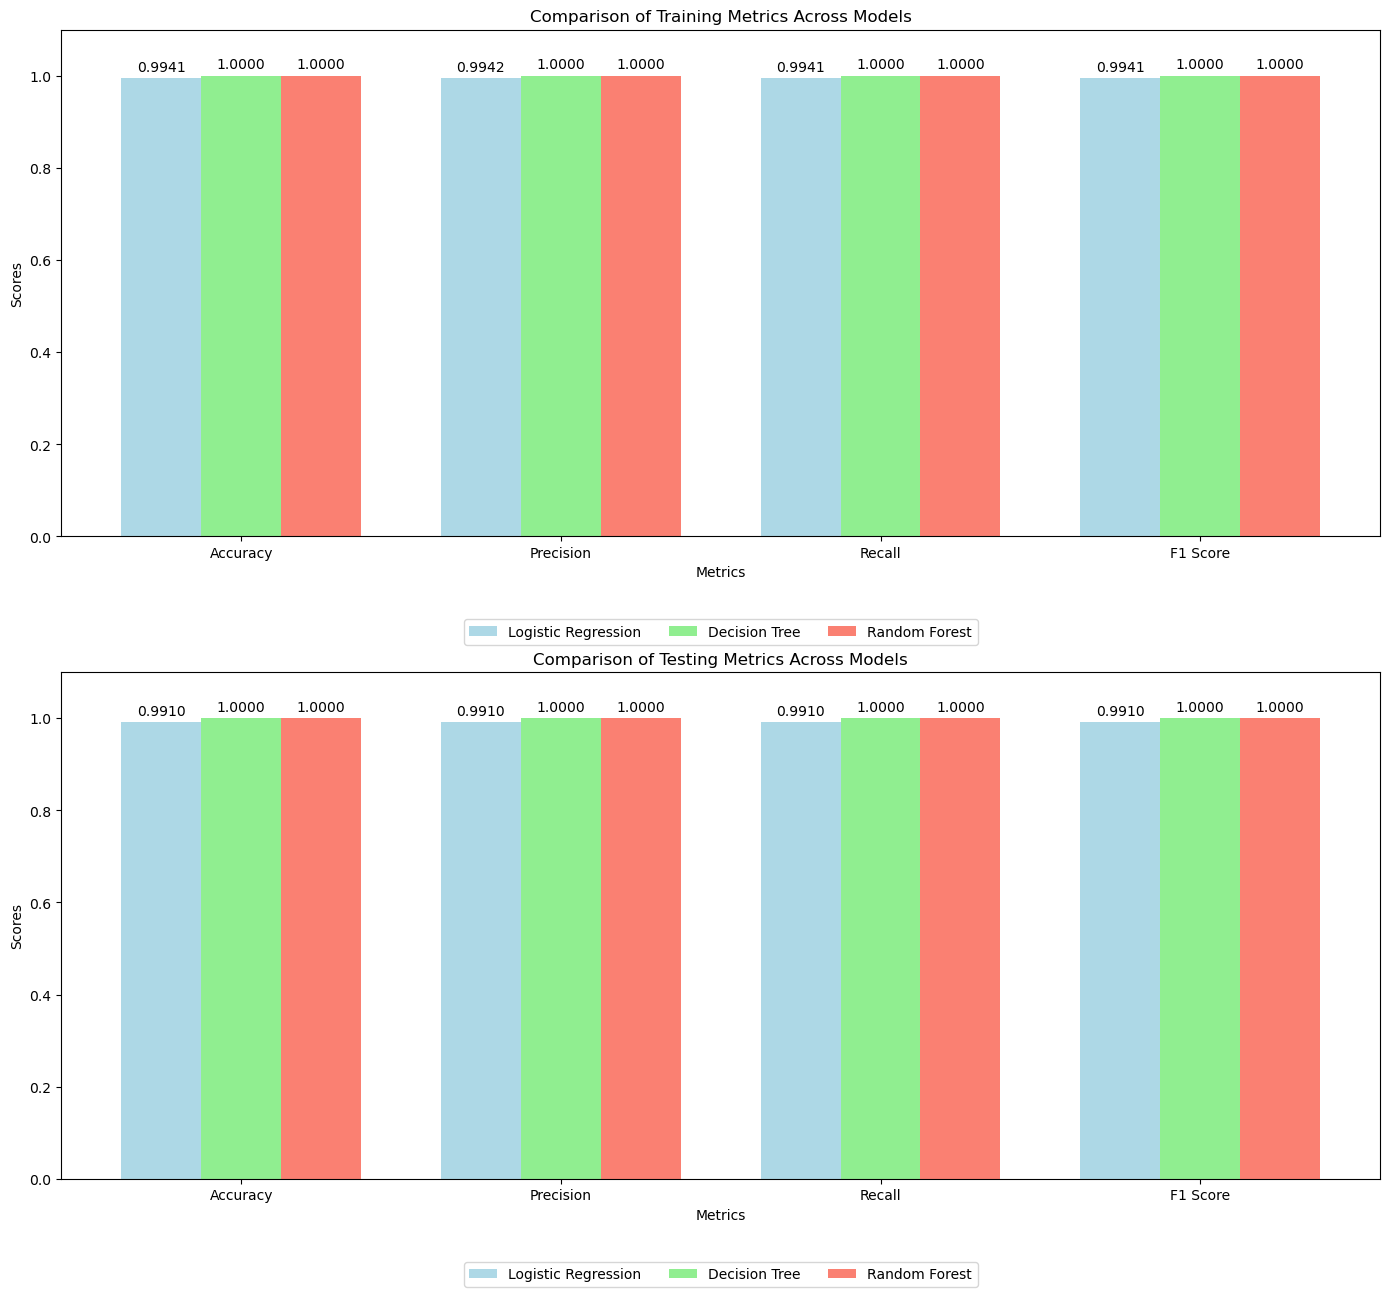

In [25]:
plot_metrics(model_metrics)

In [26]:
# Print convergence points
print("Convergence Points:")
for name, (point, score) in convergence_points.items():
    print(f"{name}: {point} training examples with a score of {score:.3f}")


Convergence Points:
Logistic Regression: 3172 training examples with a score of 0.997
Decision Tree: 951 training examples with a score of 1.000
Random Forest: 1268 training examples with a score of 1.000


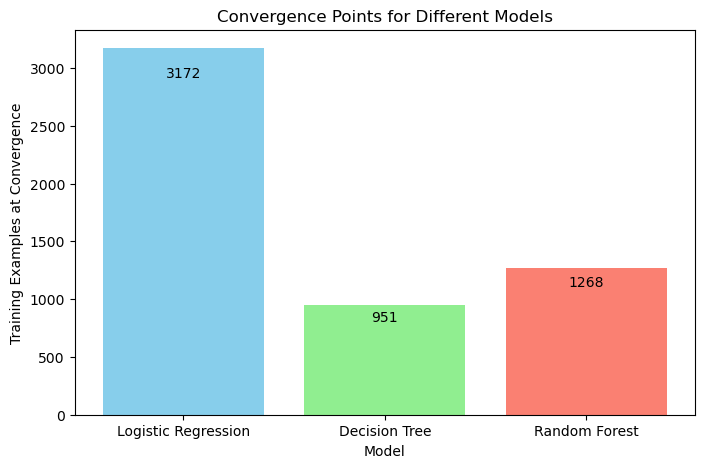

In [27]:
# Plot convergence points
plt.figure(figsize=(8, 5))

# Extract values for plotting
convergence_values = [point for point, _ in convergence_points.values()]  # Extract only the training examples
model_names = list(convergence_points.keys())

# Plot the bar graph
bars = plt.bar(model_names, convergence_values, color=['skyblue', 'lightgreen', 'salmon'])

# Add labels inside the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval - (yval * 0.05), int(yval), ha='center', va='top', color='black')

# Set title and labels
plt.title('Convergence Points for Different Models')
plt.xlabel('Model')
plt.ylabel('Training Examples at Convergence')

# Show the plot
plt.show()


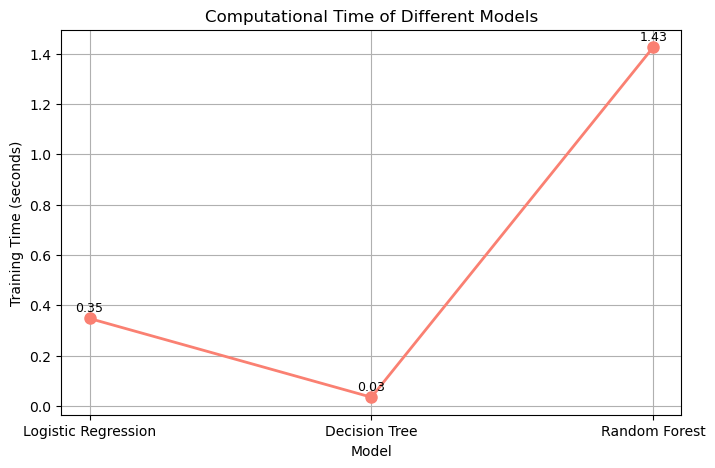

In [28]:
# Dictionary to store the training times of each model
training_times = {
    'Logistic Regression': logistic_training_time,
    'Decision Tree': decision_tree_training_time,
    'Random Forest': random_forest_training_time
}

#Plot computational time
plot_computational_time(training_times)
